In [8]:
import re, os #regular expression for removing punctuations
import requests #read the British to American dictionary
import pandas as pd
import csv
from PIL import Image, ImageColor
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Make sure to run python -m spacy download en_core_web_sm beforehand
import spacy #for tokenization and lemmatization
nlp = spacy.load('en_core_web_sm')
lemmatizer = nlp.get_pipe("lemmatizer")

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn #to use WordNet
from nltk import pos_tag

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jinhanz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jinhanz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jinhanz/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /home/jinhanz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american = requests.get(url).json()

excluded_response = ["can't","cannot","can not","can't see","cant see",'barely see','cannot see','no see',"not see", "dont see", "hardly see", 'cammot see',"didnt see","dont really see","seems nobody","cnt see"]

In [ ]:
# Helpers

def preprocess(row):
    #TODO: how to handle trials skipped with empty explanation? shouldn't count it in when calculating score mean for this subject (Fine if we get 0 scores which has no effect when taking average?)
    if pd.isna(row['text']): return []

    # Clean trials where subject answer they didn't see the image
    for keywords in excluded_response:
        if keywords in row['text'].lower():
            return []  

    string = re.sub(r'[^\w\s]', '', row['text'].strip()) #Remove punctuations
    sentence = nlp(string) #Apply Spacy
    lemma_list = [token.lemma_ for token in sentence] #Lemmatization
    am_list = [] #Empty list to put changed spellings
    for word in lemma_list:
        if word in british_to_american:
            am_list.append(british_to_american[word]) #Replace with American spelling if there is a difference
        else:
            am_list.append(word) #Just append the original word if there is no difference
    return am_list


def get_rating(item):
    rating = {}
    with open('./sensorimotor.csv') as file: #Read the file with sensorimotor strength ratings
        reader = csv.DictReader(file)
        for row in reader:
            rating[row['word']] = float(row[item]) #Convert ratings into dictionaries
    return rating

visual_dict = get_rating('visual')

def avg_rating(row, dict_name): #Calculate average rating per word for each explanation
    rating_list = []
    for lemma in row['tokenized']:
        lemma = lemma.upper()
        if lemma in dict_name:
            rating_list.append(dict_name[lemma])
    if len(rating_list) != 0:
        return sum(rating_list)/len(rating_list)
    else:
        return 0
    
max(visual_dict.values())

wn_lemmas = set(wn.all_lemma_names()) #Get all lemmas in WordNet

def avg_similarity(row, col): #Calculate average similarity to the label for each explanation
    sim_list = []
    label = "_".join(row[col].split(' ')) #Dealing with the special case of the two-word label, tennis ball
    # NOTE: remove "potted_plant" has no synset
    for lemma in row['tokenized']:
        if lemma in wn_lemmas: #Check if the word is in WordNet
            sim = wn.synsets(label)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False) #Disable simulate root so that we only get similarities for nouns
            if sim is not None: #For other parts of speech, similarity will be empty
                sim_list.append(sim)
    if len(sim_list) != 0:
        return sum(sim_list)/len(sim_list)
    else:
        return 0
    
def valid_wordnet_vocab(row, col): #Calculate average similarity to the label for each explanation
    vocab_list = []
    label = row[col]
    label = "_".join(row[col].split(' ')) #Dealing with the special case of the two-word label, tennis ball
    for lemma in row['tokenized']:
        if lemma in wn_lemmas: #Check if the word is in WordNet
            sim = wn.synsets(label)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False) #Disable simulate root so that we only get similarities for nouns
            if sim is not None: #For other parts of speech, similarity will be empty
                vocab_list.append(lemma)
    return vocab_list

# Function to determine the color of the word based on POS
def get_color(word, pos):
    color_dict = {
        'NN': 'blue',    # Noun
        'VB': 'green',   # Verb
        'JJ': 'red',     # Adjective
        'RB': 'purple',  # Adverb
    }
    return color_dict.get(pos[:2], 'black')

# Function to create the word cloud
def create_word_cloud(word_freq, tagged_words, word_values, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', mode='RGBA', collocations=False)
    
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if word.lower() in word_values:
            pos = [tag for (w, tag) in tagged_words if w == word][0]
            color = get_color(word, pos)
            rgb = ImageColor.getrgb(color)
            alpha = int(word_values.get(word, 1.0) * 255)
            return (rgb[0], rgb[1], rgb[2], alpha)
        else: # words not included when calculating the score
            color = "orange"
            rgb = ImageColor.getrgb(color)
            alpha = 1
            return (rgb[0], rgb[1], rgb[2], alpha)

    wordcloud.generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3), interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [5]:
root = "."
exp_all_datasets = {}

mscoco_category2label = {
    'person': 'human',
    'car': 'vehicle',
    'bus': 'vehicle',
    'truck': 'vehicle'
}

for dataset in ['mscoco','vehicle','human']:
    file = f"exp_{dataset}.csv"

    exp = pd.read_csv(os.path.join(root, file)) #Read the file with explanation text

    if dataset == 'mscoco':
        exp['category'] = exp['label']
        exp['label'] = exp['category'].apply(lambda x: mscoco_category2label[x] if x in mscoco_category2label else x)
        exp = exp[exp['label'].isin(['vehicle','human'])]

    # BDD Label: vehicle, human
    # BDD Category: person, rider, car, bus, truck
    exp = exp.astype({'text':'string','image':'string','label':'string','category':'string'})

    exp['tokenized'] = exp.apply(lambda row: preprocess(row), axis = 1) #Process explanations

    exp['visual'] = exp.apply(lambda row: avg_rating(row, visual_dict), axis = 1) #Get visual strength for each explanation

    exp['wordnet_similarity_label'] = exp.apply(lambda row: avg_similarity(row, 'label'), axis = 1) #Get WordNet similarity for each explanation
    exp['wordnet_similarity_category'] = exp.apply(lambda row: avg_similarity(row, 'category'), axis = 1) #Get WordNet similarity for each explanation
    exp['wordnet_vocab'] = exp.apply(lambda row: valid_wordnet_vocab(row, 'category'), axis = 1) #Get WordNet similarity for each explanation

    exp_all_datasets[dataset] = exp

Should the explanation with original word be excluded?

### WordCloud (MSCOCO)

In [12]:
exp.head()

,subject_no,Trial_Index_,block,text,block_sequence,block_name,block_num,path,image,trialID,label,category,number,lastBlockType,tokenized,visual,wordnet_similarity_label,wordnet_similarity_category,wordnet_vocab
0,1,1,2,he is walking with legs,2,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,411.jpg,1,human,person,NaN,NaN,"[he, be, walk, with, leg]",3.197386,0.051964,0.111195,"[he, be, walk, leg]"
1,1,2,2,slim with legs and hand,2,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,608.jpg,2,human,person,NaN,NaN,"[slim, with, leg, and, hand]",3.422308,0.051316,0.105556,"[leg, hand]"
2,1,3,2,human face,2,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,480.jpg,3,human,person,NaN,NaN,"[human, face]",4.836111,0.527778,0.112500,"[human, face]"
3,1,4,2,human cloth with hat,2,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,85.jpg,4,human,person,NaN,NaN,"[human, cloth, with, hat]",4.298203,0.379808,0.125926,"[human, cloth, hat]"
4,1,5,2,human back with t shirt,2,exp_car1,1,/Hum_ExpTask_Test1_deploy/results/001ET1,703.jpg,5,human,person,NaN,NaN,"[human, back, with, t, shirt]",3.950868,0.292236,0.111219,"[human, back, t, shirt]"


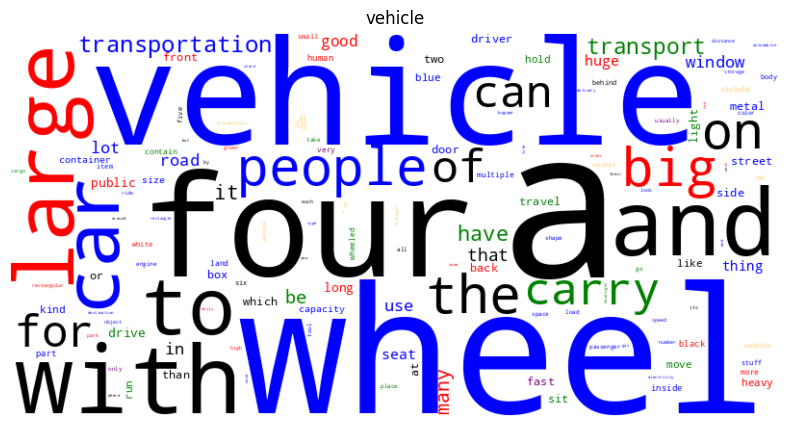

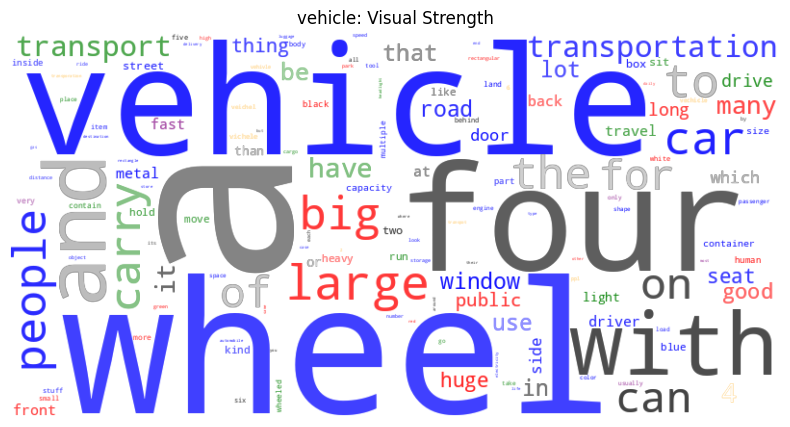

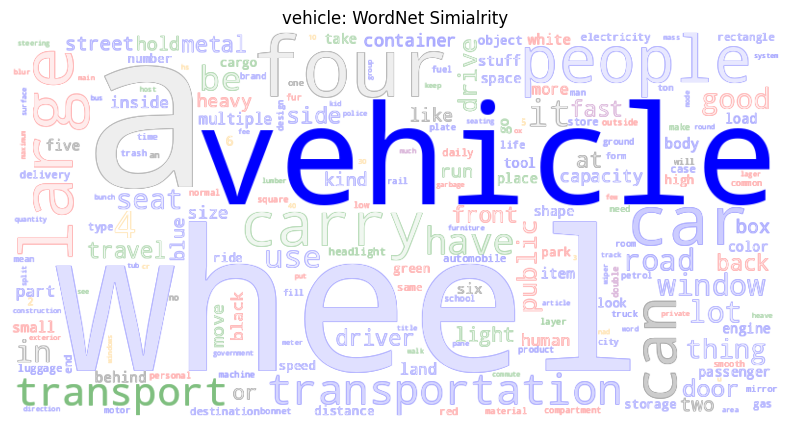

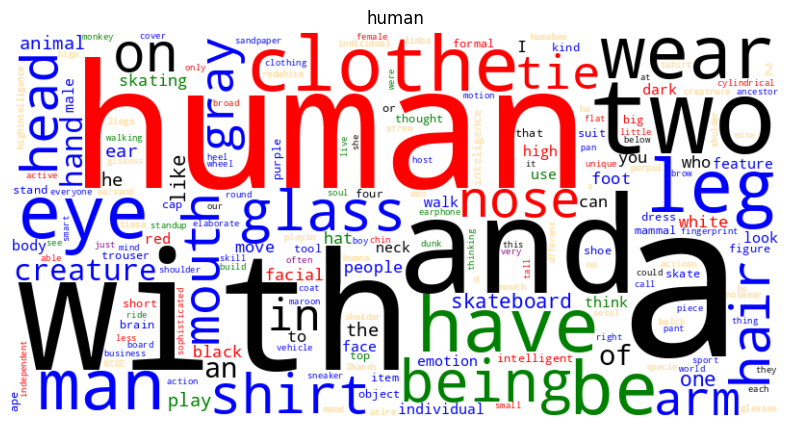

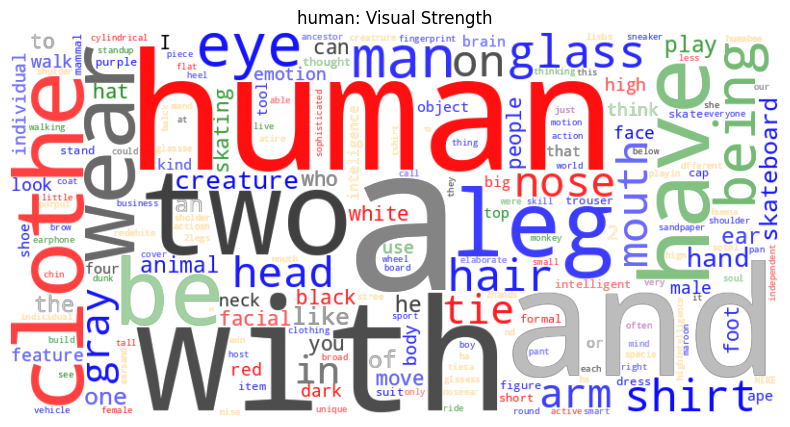

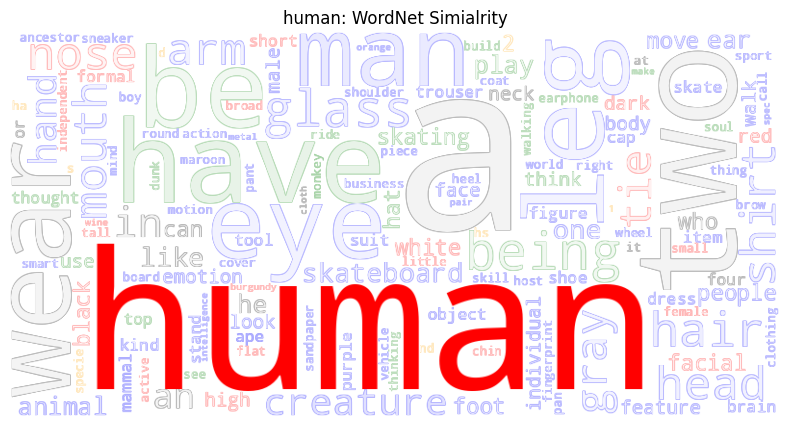

In [13]:
# Create a list of all words in the dataframe
exp = exp_all_datasets['mscoco']

for category in ['vehicle','human']:

    ## Visual information 
    all_words = []
    for tokenized in exp[exp['label']==category]['tokenized']:
        all_words.extend(tokenized)

    # Tag words with their POS
    tagged_words = pos_tag(all_words)

    # Create a dictionary of word frequencies
    word_freq = nltk.FreqDist(all_words)

    # Visual strength
    visual_strength = {}
    no_score = {}
    for lemma in word_freq:
        lemma = lemma.upper()
        if lemma in visual_dict:
            visual_strength[lemma.lower()] = visual_dict[lemma] / 5 # visual strength [0,5]
            no_score[lemma.lower()] = 1 # Also generate a word cloud without scores

    # Generate and display the word cloud
    create_word_cloud(word_freq, tagged_words, no_score, title=f"{category}")
    create_word_cloud(word_freq, tagged_words, visual_strength, title=f"{category}: Visual Strength")

    ## Conceptual information
    all_words = []
    for tokenized in exp[exp['label']==category]['wordnet_vocab']:
        all_words.extend(tokenized)

    # Create a dictionary of word frequencies
    word_freq = nltk.FreqDist(all_words)

    # WordNet Similarity
    wordnet_similarity = {}
    for lemma in word_freq:
        lemma = lemma.upper()
        if lemma in visual_dict:
            wordnet_similarity[lemma.lower()] = wn.synsets(category)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False)

    # Generate and display the word cloud
    create_word_cloud(word_freq, tagged_words, wordnet_similarity,title=f"{category}: WordNet Simialrity")

## Wordcloud (BDD)

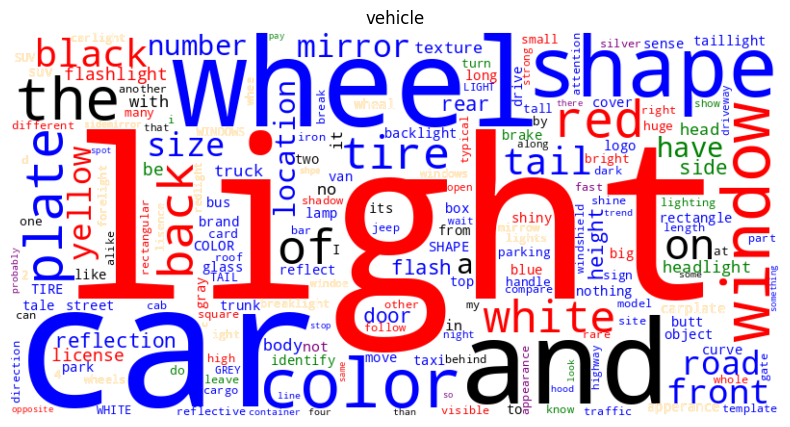

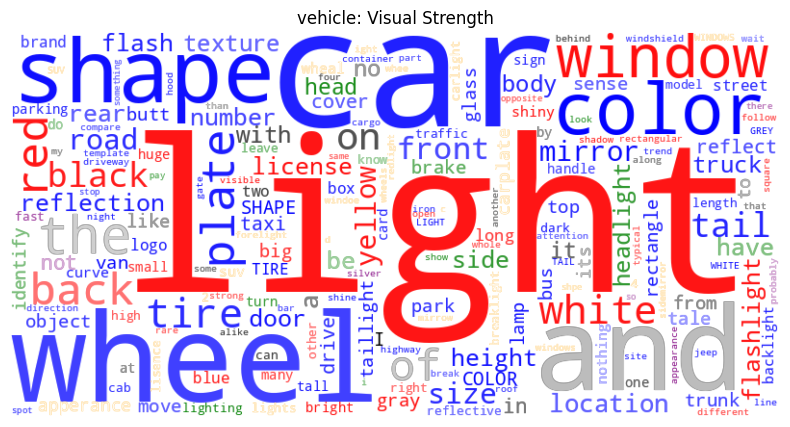

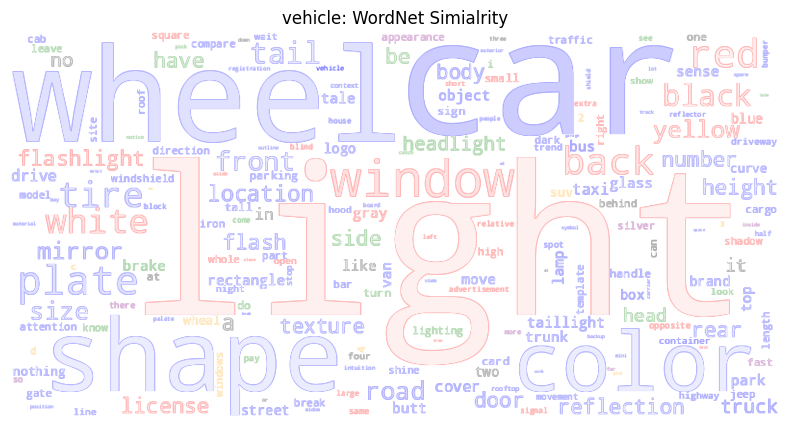

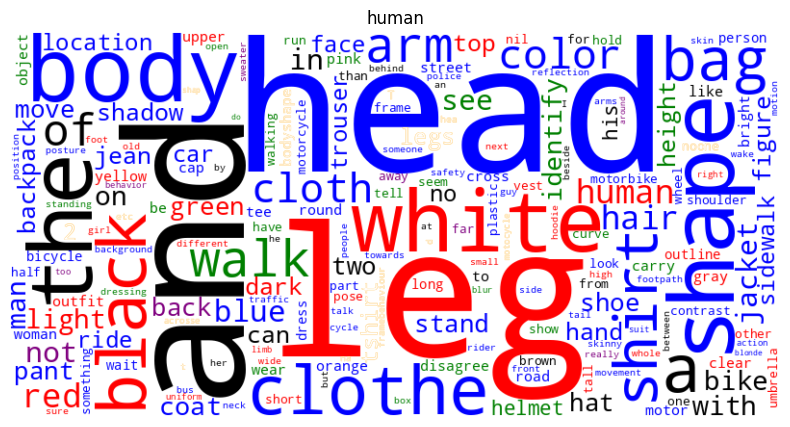

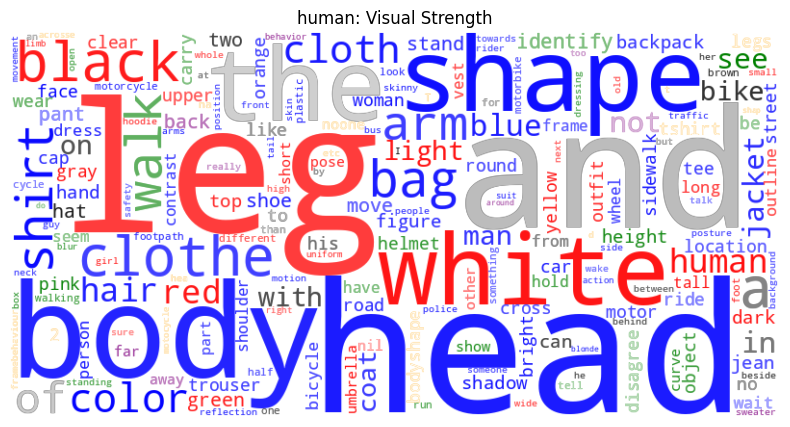

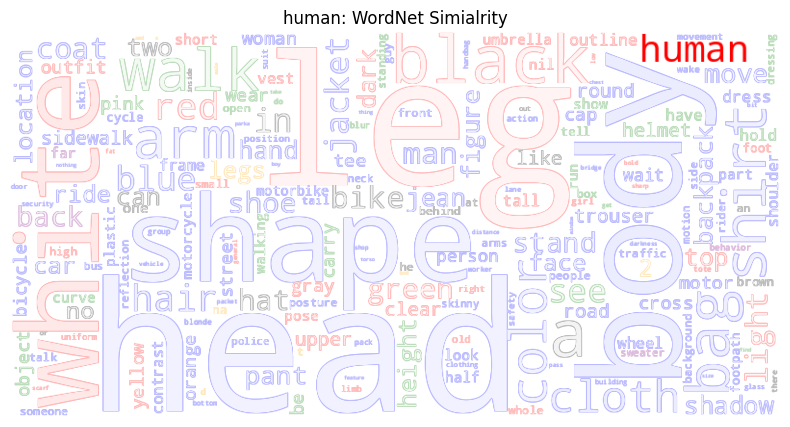

In [15]:
# Create a list of all words in the dataframe
for category in ['vehicle','human']:

    exp = exp_all_datasets[category]
        
    ## Visual information 
    all_words = []
    for tokenized in exp[exp['label']==category]['tokenized']:
        all_words.extend(tokenized)

    # Tag words with their POS
    tagged_words = pos_tag(all_words)

    # Create a dictionary of word frequencies
    word_freq = nltk.FreqDist(all_words)

    # Visual strength
    visual_strength = {}
    no_score = {}
    for lemma in word_freq:
        lemma = lemma.upper()
        if lemma in visual_dict:
            visual_strength[lemma.lower()] = visual_dict[lemma] / 5 # visual strength [0,5]
            no_score[lemma.lower()] = 1 # Also generate a word cloud without scores

    # Generate and display the word cloud
    create_word_cloud(word_freq, tagged_words, no_score, title=f"{category}")
    create_word_cloud(word_freq, tagged_words, visual_strength, title=f"{category}: Visual Strength")

    ## Conceptual information
    all_words = []
    for tokenized in exp[exp['label']==category]['wordnet_vocab']:
        all_words.extend(tokenized)

    # Create a dictionary of word frequencies
    word_freq = nltk.FreqDist(all_words)

    # WordNet Similarity
    wordnet_similarity = {}
    for lemma in word_freq:
        lemma = lemma.upper()
        if lemma in visual_dict:
            wordnet_similarity[lemma.lower()] = wn.synsets(category)[0].path_similarity(wn.synsets(lemma)[0],simulate_root = False)

    # Generate and display the word cloud
    create_word_cloud(word_freq, tagged_words, wordnet_similarity,title=f"{category}: WordNet Simialrity")